# Sentiment Analysis on Student Essays

This notebook performs **Sentiment Analysis** on a dataset of student essays. The goal is to determine whether each essay's sentiment is positive, neutral, or negative using basic natural language processing (NLP) and machine learning techniques.



## Importing Necessary Libraries

I begin by importing the necessary libraries for data manipulation, visualization, text preprocessing, and machine learning:
- **Pandas**: For data manipulation.
- **String**: To handle text operations like removing punctuation.
- **NLTK**: For natural language processing tasks such as tokenization, stopword removal, and sentiment analysis.
- **Matplotlib/Seaborn**: For visualizing data and results.
- **Scikit-learn**: For machine learning models, feature extraction, and evaluation.
- **WordCloud**: To generate word cloud visualizations of frequent terms.

In [2]:
import pandas as pd
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/albertasmervik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/albertasmervik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/albertasmervik/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True


## Data preparation: Data Loading

In this section, we load the dataset using pandas. The dataset contains various columns related to essay texts, their start and end positions, and other metadata. 

Question: Am i at fault for choosing a dataset that is already structured for a certain analysis?, i feel like its weird to backward engineer the dataset, or is this pretty normal


In [3]:
df = pd.read_csv('dataset/sample_information.csv')
df.head(5)

,id,start,end,text,class,predictionstring
0,E05C7F5C1156,0,455,People are debating whether if drivers should ...,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,E05C7F5C1156,455,527,I also think that you shouldn't use your phone...,Position,77 78 79 80 81 82 83 84 85 86 87 88 89
2,E05C7F5C1156,528,568,because it can cause vehicle collisions,Claim,90 91 92 93 94 95
3,E05C7F5C1156,569,588,"slow reaction time,",Claim,96 97 98
4,E05C7F5C1156,589,609,and fatal injuries.,Claim,99 100 101



## Data preparation: Data Cleaning

we clean the dataset by removing unnecessary columns and handling missing values. We also join the texts together by their ID, Since they were split in the starting set due to the division of different classes. We are also using info() to look for any missing values. 



In [4]:
df_cleaned = df.drop(columns=['start', 'end', 'class', 'predictionstring'])

In [5]:
df_combined = df_cleaned.groupby('id')['text'].apply(lambda x: ' '.join(x)).reset_index()

In [6]:
df_combined.head()

,id,text
0,00A4CB36E006,Do you get advice from people? Many people do ...
1,01604A97F0C3,Every person needs some form of transportation...
2,01DB053153E0,Students deserve a break from school altogethe...
3,023CEE52C08C,"In the article ""The Challenge of Exploring Ven..."
4,0266C68066E7,Driverless cars have positives which they hold...


In [7]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      500 non-null    object
 1   text    500 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB



## Data preparation : Text Preprocessing

In this step, I preprocess the essay text by:
- Converting all text to lowercase to ensure uniformity.
- Removing punctuation and digits to reduce noise.
- Tokenizing the text into individual words.
- Removing common English stopwords that don’t contribute to sentiment analysis.




In [8]:

def preprocess_text(text):
    text = text.lower()
    
    text = ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])
    
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Rejoin tokens into a cleaned text
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Applying the function to our df
df_combined['cleaned_text'] = df_combined['text'].apply(preprocess_text)

df_combined.head()

    

,id,text,cleaned_text
0,00A4CB36E006,Do you get advice from people? Many people do ...,get advice people many people go one person sa...
1,01604A97F0C3,Every person needs some form of transportation...,every person needs form transportation people ...
2,01DB053153E0,Students deserve a break from school altogethe...,students deserve break school altogether loade...
3,023CEE52C08C,"In the article ""The Challenge of Exploring Ven...",article challenge exploring venus tals sciente...
4,0266C68066E7,Driverless cars have positives which they hold...,driverless cars positives hold total perspecti...


## Sentiment Classification with VADER

we use the **VADER** sentiment analyzer to classify each essay into Positive, Neutral, or Negative categories. The compound score provided by VADER is used to determine the sentiment, with a threshold of 0.05 and -0.05 to allow for neutral classification while ensuring some flexibility for positive and negative sentiments. Do not know for certain that this is something that we are advised to be doing, but i find it hard to belive that the score for positive should be >0 and minus <0. that means the only texts that will be deemed neutral are those with sentiment score of 0.0

Question : is this practice normal? i learned that the default compound is <0 and >0, what do you think about tempering with the value for a better samplesize?
 


In [9]:

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to classify the sentiment based on VADER scores
def classify_sentiment(text):
    # Get the sentiment scores for the text
    scores = sia.polarity_scores(text)
    
    # Here i decided to have it set to 0.05 and -0.05 to be able to capture some neutral sentiments 
    if scores['compound'] >= 0.05:
        return 'Positive'
    elif scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Applying the function to our df
df_combined['sentiment'] = df_combined['cleaned_text'].apply(classify_sentiment)

df_combined[['cleaned_text', 'sentiment']].head()


,cleaned_text,sentiment
0,get advice people many people go one person sa...,Positive
1,every person needs form transportation people ...,Positive
2,students deserve break school altogether loade...,Positive
3,article challenge exploring venus tals sciente...,Positive
4,driverless cars positives hold total perspecti...,Positive


In [10]:
df_combined['sentiment'].value_counts()

sentiment
Positive    420
Negative     74
Neutral       6
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)

In this section, we will visualize the distribution of sentiments in the dataset and explore other patterns, such as essay lengths and frequently occurring words, to better understand the data.

## EDA: Sentiment Distribution

we visualize the distribution of sentiment labels in the dataset using a count plot. This shows the frequency of each sentiment category (Positive, Neutral, Negative) and helps us understand the balance of the dataset.


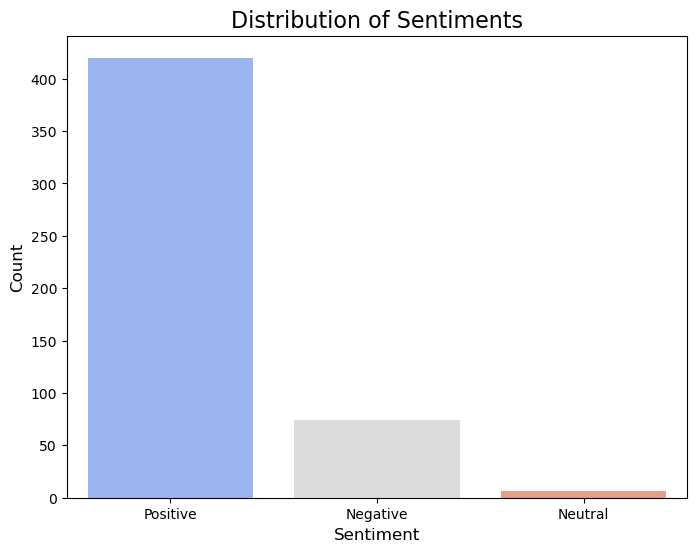

In [11]:
plt.figure(figsize=(8, 6))

sns.countplot(x='sentiment', data=df_combined, hue='sentiment', palette="coolwarm", legend=False)

plt.title('Distribution of Sentiments', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()




## EDA: Wordcloud visualization by sentiment

we generate word clouds for each sentiment category (Positive, Neutral, Negative) to visualize the most frequent words associated with each sentiment. Word clouds help us understand which terms are commonly used in essays expressing different sentiments.


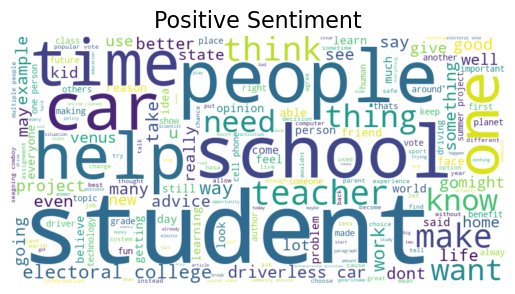

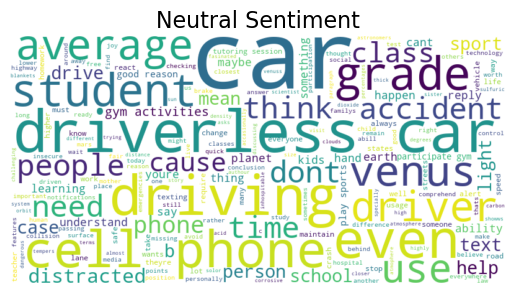

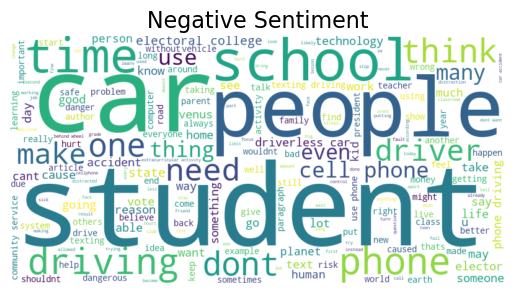

In [12]:
def plot_wordcloud(sentiment):
    text = " ".join(df_combined[df_combined['sentiment'] == sentiment]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{sentiment} Sentiment', fontsize=16)
    plt.axis('off')
    plt.show()

# Generate word clouds for each sentiment
for sentiment in ['Positive', 'Neutral', 'Negative']:
    plot_wordcloud(sentiment)



## EDA: Essay Length distribution

Here we calculate the length of each essay (in terms of the number of words) and visualize the distribution of essay lengths across different sentiment categories. This helps us explore whether essay length varies significantly based on sentiment and may provide insights into how sentiment is expressed in writing.


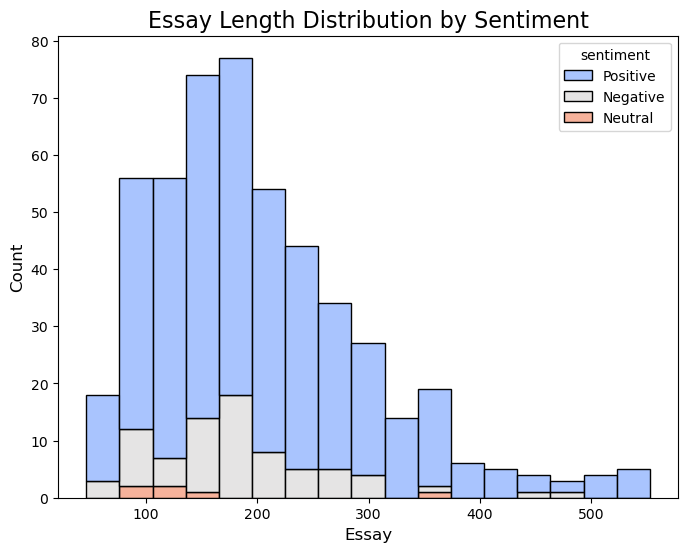

In [22]:
# Calculating the essay length (number of words) for each essay
df_combined['essay_length'] = df_combined['cleaned_text'].apply(lambda x: len(x.split()))


plt.figure(figsize=(8, 6))

# Plot the essay length distribution for each sentiment
sns.histplot(data=df_combined, x='essay_length', hue='sentiment', multiple='stack', palette='coolwarm')


plt.title('Essay Length Distribution by Sentiment', fontsize=16)
plt.xlabel('Essay', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()


### Step: Converting Text to Numerical Features with TF-IDF

In this step, we use TfidfVectorizer to convert the cleaned essay text into a numerical matrix. We limit the feature to 200 words and remove common stopwords. We then apply the cleaned text to get the TF-IDF feauture matrix.
The reason i went with TF-IDF, instead of BoW follows. From my understanding and research, TF-IDF suits this project alot better, while BoW only counts the words and threats them as "likemen" TF-IDF considers how important certain words are.


In [14]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=200, stop_words='english')

# Fit and transform the cleaned text data into TF-IDF feature matrix
X_tfidf = tfidf_vectorizer.fit_transform(df_combined['cleaned_text'])

# Print the shape of the resulting TF-IDF matrix
print(f"Shape of TF-IDF feature matrix: {X_tfidf.shape}")

# Convert to a DataFrame to easily inspect some features
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.head()


Shape of TF-IDF feature matrix: (500, 200)


,able,accidents,activities,activity,actually,advice,agree,allow,article,ask,...,want,way,ways,work,working,world,wouldnt,wrong,year,years
0,0.000000,0.000000,0.0,0.0,0.0,0.639452,0.000000,0.0,0.000000,0.0,...,0.079612,0.056937,0.0,0.000000,0.000000,0.000000,0.000000,0.063037,0.0,0.000000
1,0.103937,0.082299,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.044511,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.066922,0.0,0.000000,0.0,...,0.121160,0.000000,0.0,0.176359,0.067278,0.160343,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.059684,0.0,...,0.075013,0.000000,0.0,0.040946,0.249922,0.000000,0.000000,0.000000,0.0,0.000000
4,0.023741,0.037596,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.021324,0.020334,0.0,0.000000,0.000000,0.028220,0.030659,0.000000,0.0,0.032833


## Modeling: Splitting 

the dataset is split into training and testing sets, with 80% of the data used for training and 20% reserved for testing. This ensures that the model is trained on one portion of the data and evaluated on a separate, unseen portion, providing a more accurate assessment of its performance. 

In [23]:
# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df_combined['sentiment'], test_size=0.2, random_state=42) 
# Stratify

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (400, 200)
Testing set size: (100, 200)



## Modelling: Logistic Regression Model and Evaluation

In this step, we implement **Logistic Regression** model to classify the sentiment of the essays. After training the model on the training set, we evaluate its performance on the test set using a classification report and accuracy score. These metrics give us an understanding of how well the model is performing in terms of prediction accuracy and classification quality.


In [16]:
# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)

# Train the model
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred_logreg = logreg.predict(X_test)

# Evaluate the performance
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_logreg, zero_division=0))
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.4f}")


Logistic Regression Classification Report:

              precision    recall  f1-score   support

    Negative       1.00      0.32      0.48        19
     Neutral       0.00      0.00      0.00         1
    Positive       0.85      1.00      0.92        80

    accuracy                           0.86       100
   macro avg       0.62      0.44      0.47       100
weighted avg       0.87      0.86      0.83       100

Accuracy: 0.8600


## Evaluation: Model Evaluation

While the model performs well for the Positiveclass (with an accuracy of 86%), it struggles with the Negative and Neutral classes, as reflected in the lower recall for these categories. This suggests class imbalance or challenges in differentiating between these sentiments.

I also experimented with other models, including Naive Bayes and Support Vector Machine. The results were consistent across these models: the Positive class was handled well, but performance on Negative and Neutral classes remained poor, indicating that further data preprocessing or balancing techniques may be required.



## Evaluation: Confusion Matrix for Model Evaluation

The confusion matrix provides a visual confirmation of the performance issues we discussed earlier in the model evaluation. While the Positive class is predicted with high acuracy, the model struggles with the Negative and Neutral classes, making only a few correct predictions for Negative and none for Neutral. This supports our earlier observation that the model faces challenges in distinguishing these sentiments, likely due to class imbalance. 

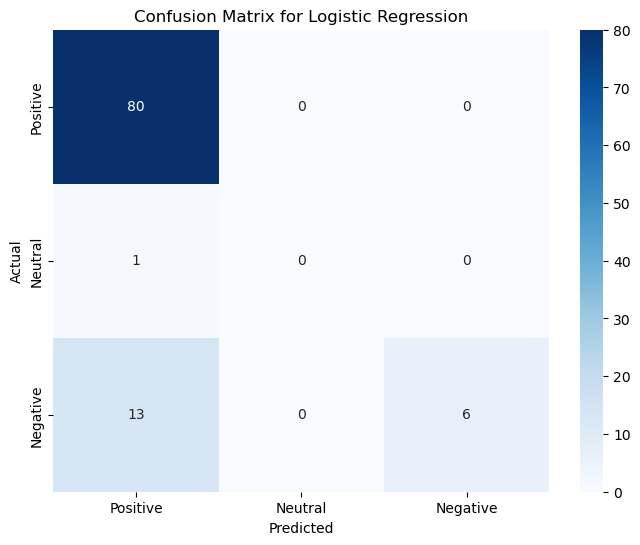

In [17]:
# Generate confusion matrix for Logistic Regression (replace with other models as needed)
cm = confusion_matrix(y_test, y_pred_logreg, labels=['Positive', 'Neutral', 'Negative'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


## Project Extension: Improving Model Performance

The initial Logistic Regression model showed strong performance for the Positive sentiment but struggled with the Negative and Neutral classes, likely due to class imbalance. In this project extension, we explore several methods to improve the model’s performance by addressing this imbalance:
   
1. **Class Balancing**: We apply techniques such as oversampling with SMOTE and adjusting class weights to give the model more focus on underrepresented classes.
   
2. **Re-Tuning the Model**: After balancing, we retrain the model and explore other algorithms like Random Forest and SVM.
   
3. **Evaluation**: We compare the new models against the original Logistic Regression, assessing performance improvements in terms of recall, precision, and overall accuracy.



## Step 1 : Visualise the inbalance 

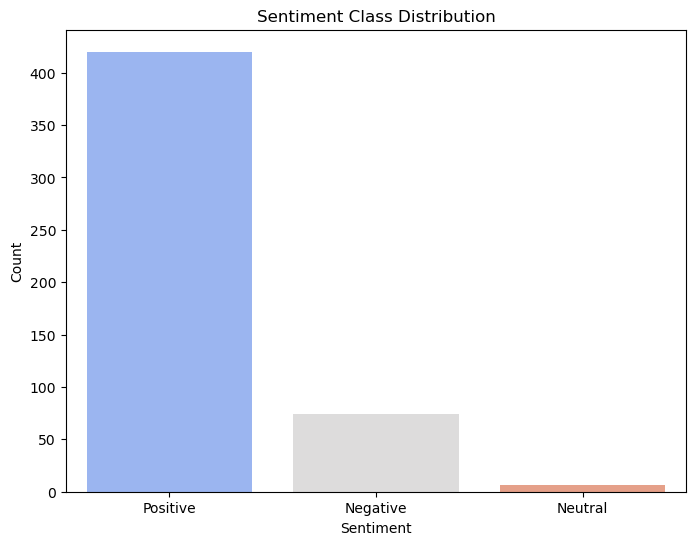

In [18]:
# Visualize the current class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_combined,hue='sentiment' ,palette='coolwarm')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## Step 2 : Applying Smote for classbalancing 

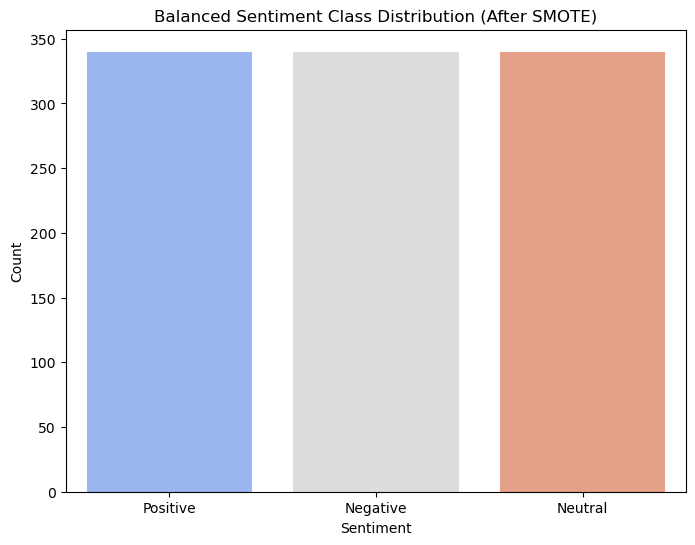

In [19]:

# Apply SMOTE to balance the classes in the training data
smote = SMOTE(random_state=42, k_neighbors=1)  # k_neighbors=1 since Neutral has only 5 samples
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled, hue=y_resampled, palette='coolwarm', legend=False)
plt.title('Balanced Sentiment Class Distribution (After SMOTE)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


## Step 3 : Retraining the model

In [20]:
# Re-train Logistic Regression on balanced data
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_resampled, y_resampled)

# Predict on the original test set
y_pred_logreg_balanced = logreg.predict(X_test)

# Evaluate the balanced model
print("Balanced Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_logreg_balanced))
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg_balanced):.4f}")


Balanced Logistic Regression Classification Report:

              precision    recall  f1-score   support

    Negative       0.36      0.42      0.39        19
     Neutral       0.00      0.00      0.00         1
    Positive       0.85      0.80      0.83        80

    accuracy                           0.72       100
   macro avg       0.41      0.41      0.41       100
weighted avg       0.75      0.72      0.73       100

Accuracy: 0.7200


## Step 4 : Expirementing with the class weight adjustment

In [24]:
# Re-train Logistic Regression with class weights
logreg_weighted = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg_weighted.fit(X_train, y_train)

# Predict on the test set
y_pred_logreg_weighted = logreg_weighted.predict(X_test)

# Evaluate the weighted model
print("Weighted Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_logreg_weighted))
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg_weighted):.4f}")

# call the right

Weighted Logistic Regression Classification Report:

              precision    recall  f1-score   support

    Negative       0.42      0.42      0.42        19
     Neutral       0.00      0.00      0.00         1
    Positive       0.88      0.79      0.83        80

    accuracy                           0.71       100
   macro avg       0.43      0.40      0.42       100
weighted avg       0.78      0.71      0.74       100

Accuracy: 0.7100


### Results:
Despite these efforts, the improvement in classifying the Neutral and Negative classes was minimal. The lack of sufficient Neutral samples (only 5 in total) made it difficult for these methods to be effective. The Positive class continued to dominate the model's predictions, while the Neutral class performance remained poor. These results highlight the challenges of handling highly imbalanced data with few samples in the minority classes. 
